# Comparison of CDO, ClimDexCalc2, and CDS results

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from glob import glob
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

ERROR 1: PROJ: proj_create_from_database: Open of /home/b/b381815/miniconda3/envs/py/share/proj failed


In [3]:
def plot_map(ax, da, **kwargs):
    if 'cmap' not in kwargs:
        kwargs['cbar_kwargs'] = {'pad': .01}
    map_ = da.plot.pcolormesh(ax=ax, **kwargs)       
    ax.coastlines()
    ax.set_ylabel('')
    ax.set_title('')
    map_.colorbar.set_label('')
    return ax, map_

def area_weighted_mean(da):   
    cell_area = np.cos(np.deg2rad(da['lat']))
    return da.weighted(cell_area).mean(dim=('lat', 'lon'), keep_attrs=True)

In [4]:
path = '/work/uc1275/LukasBrunner/data/etccdi_cdo'

In [16]:
etccdi_indices = [
    'cdd',  'cwd', 'prcptot', 'r10mm', 'r20mm', 'r95p', 'r99p', 'rx1day', 'rx5day', 'sdii',  # pr-based 
    'csdi', 'fd', 'tn10p', 'tn90p', 'tnn', 'tnx', 'tr',  # tasmin-based  'id'
    'su', 'tx10p', 'tx90p', 'txn', 'txx', 'wsdi',  # tasmax-based
    'dtr',  # tasmin & tasmax
    'gsl',  # tas
]
# len(etccdi_indices)

# only indeces implemented directly with cdo etccdi_*
etccdi_indices = [
'cdd',
'csdi',
'cwd',
'fd',
#'id',
'r10mm',
'r20mm',
'rx1day',
'rx5day',
'su',
'tn10p',
'tn90p',
'tr',
'tx10p',
'tx90p',
'wsdi',
]

## Load cdo data

In [17]:
dict_cdo = {}
dict_freq = {}

fn_pattern = '{index}ETCCDI_*.nc'
for index in etccdi_indices:
    # print(index)
    fns = glob(os.path.join(path, 'cdo_test365day', fn_pattern.format(index=index)))
    if len(fns) != 1:
        print(fns)
        raise ValueError
    da = xr.open_dataset(fns[0], use_cftime=True, decode_timedelta=False)[f'{index}ETCCDI']
    if da.attrs['units'] == 'kg m-2 s-1':  # adjust units to match ClimDexCalc2
        da.values *= 86400
        da.attrs['units'] = 'mm/day'
    if da.attrs['units'] == 'K':
        if index != 'dtr':
            da.values -= 273.15
        da.attrs['units'] = 'degC'
        
    freq = 'MON' if 'mon' in fns[0] else 'ANN'

    dict_cdo[index] = da
    dict_freq[index] = freq
    

## Load ClimDexCalc2 data

In [18]:
dict_cdc['txx']

<xarray.DataArray 'txx' (time: 648, lat: 96, lon: 192)> Size: 48MB
[11943936 values with dtype=float32]
Coordinates:
  * time     (time) object 5kB 1961-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
Attributes:
    long_name:         Max TX
    units:             degrees_C
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  48
    comment:           includes both liquid and solid phases
    original_name:     pr
    cell_methods:      area: time: mean
    cell_measures:     area: areacella
    definition:        Monthly warmest daily TX
    expert_team:       ETCCDI

In [19]:
dict_cdc = {}

fn_pattern = '{index}_{freq}_*.nc'
for index in dict_cdo.keys():
    # print(index)
    fns = glob(os.path.join(path, 'climdexcalc2-365day', fn_pattern.format(index=index, freq=dict_freq[index].upper())))
    if len(fns) != 1:
        print(index)
        raise ValueError
    da = xr.open_dataset(fns[0], decode_timedelta=False)[f'{index}']

    dict_cdc[index] = da
    

## Load CDS data

In [20]:
dict_cds = {}
freq_map = {'ann': 'yr', 'mon': 'mon'}

fn_pattern = '{index}ETCCDI_{freq}_*.nc'
for index in dict_cdo.keys():
    # print(index)
    fns = glob(os.path.join(path, 'cds_reference', fn_pattern.format(index=index, freq=freq_map[dict_freq[index].lower()])))
    if len(fns) != 1:
        print(f'Missing: {index}')
        continue
    da = xr.open_dataset(fns[0], decode_timedelta=False)[f'{index}ETCCDI']

    dict_cds[index] = da

Missing: cdd
Missing: cwd
Missing: fd
Missing: r10mm
Missing: r20mm
Missing: rx1day
Missing: rx5day
Missing: su
Missing: tr


## Plot maps: cdo

In [21]:
period = slice('1995', '2014')

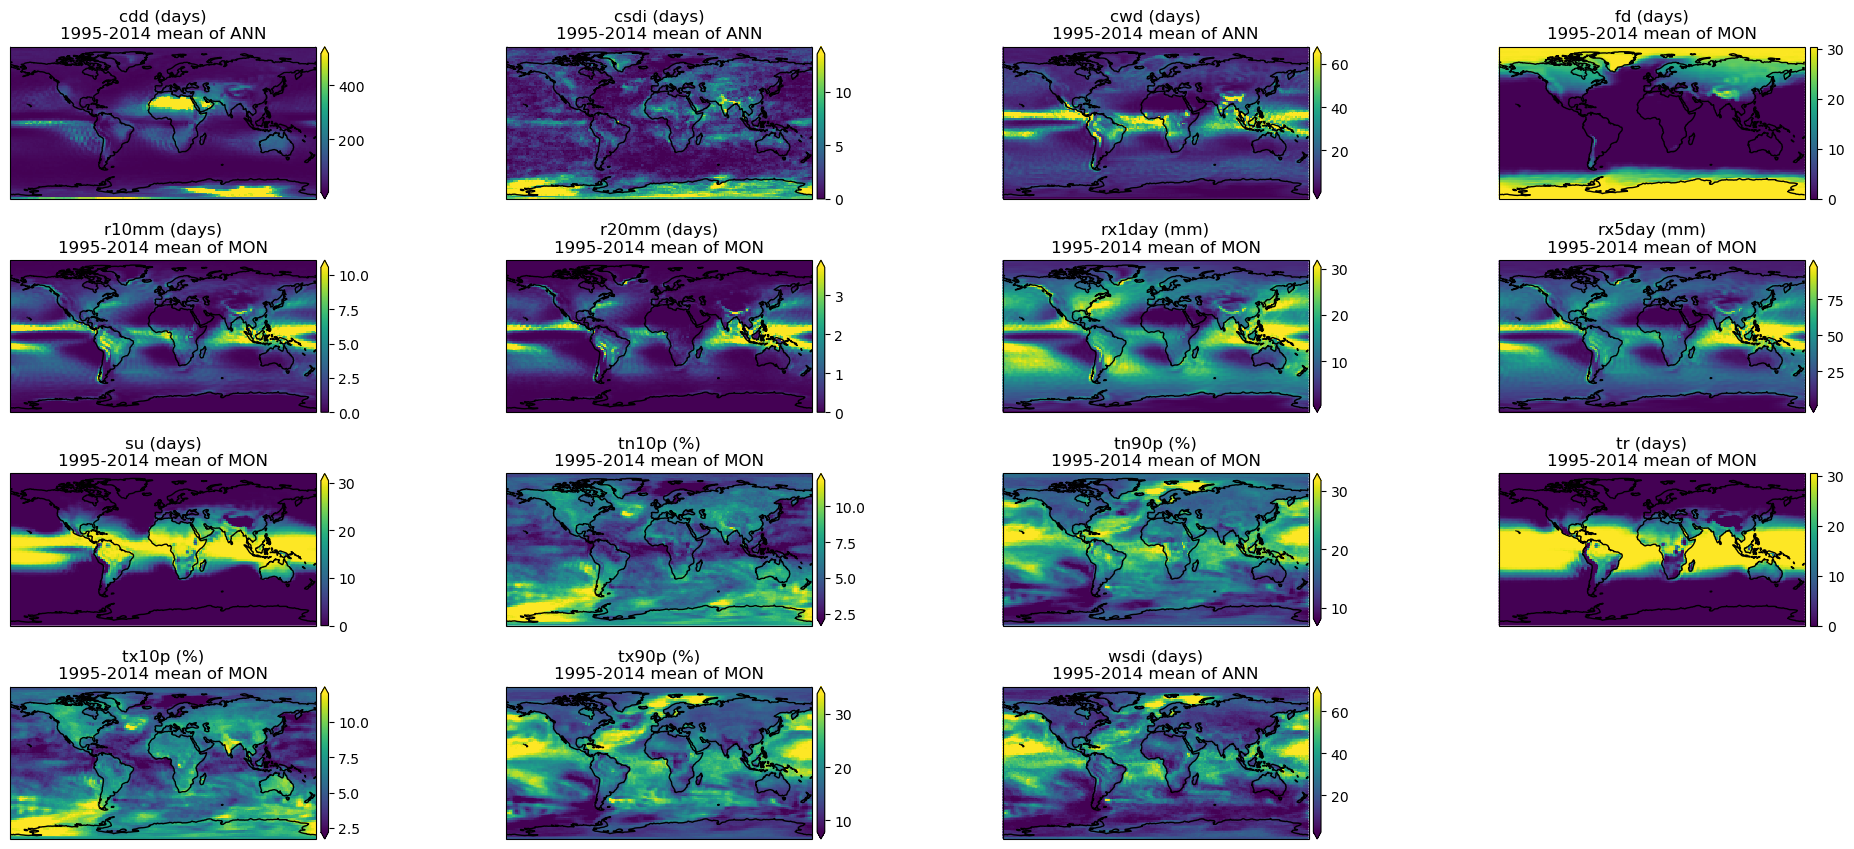

In [22]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(7, 4, subplot_kw={'projection': proj}, figsize=(20, 15))

for idx, index in enumerate(dict_cdo.keys()):
    da = dict_cdo[index]
    ax = axes.ravel()[idx]
    da = da.sel(time=period).mean('time', keep_attrs=True)   
    plot_map(ax, da, robust=True)
    ax.set_title('{} ({})\n{}-{} mean of {}'.format(
        index, da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1

fig.tight_layout()

## Plot maps: cdo - ClimDexCalc2

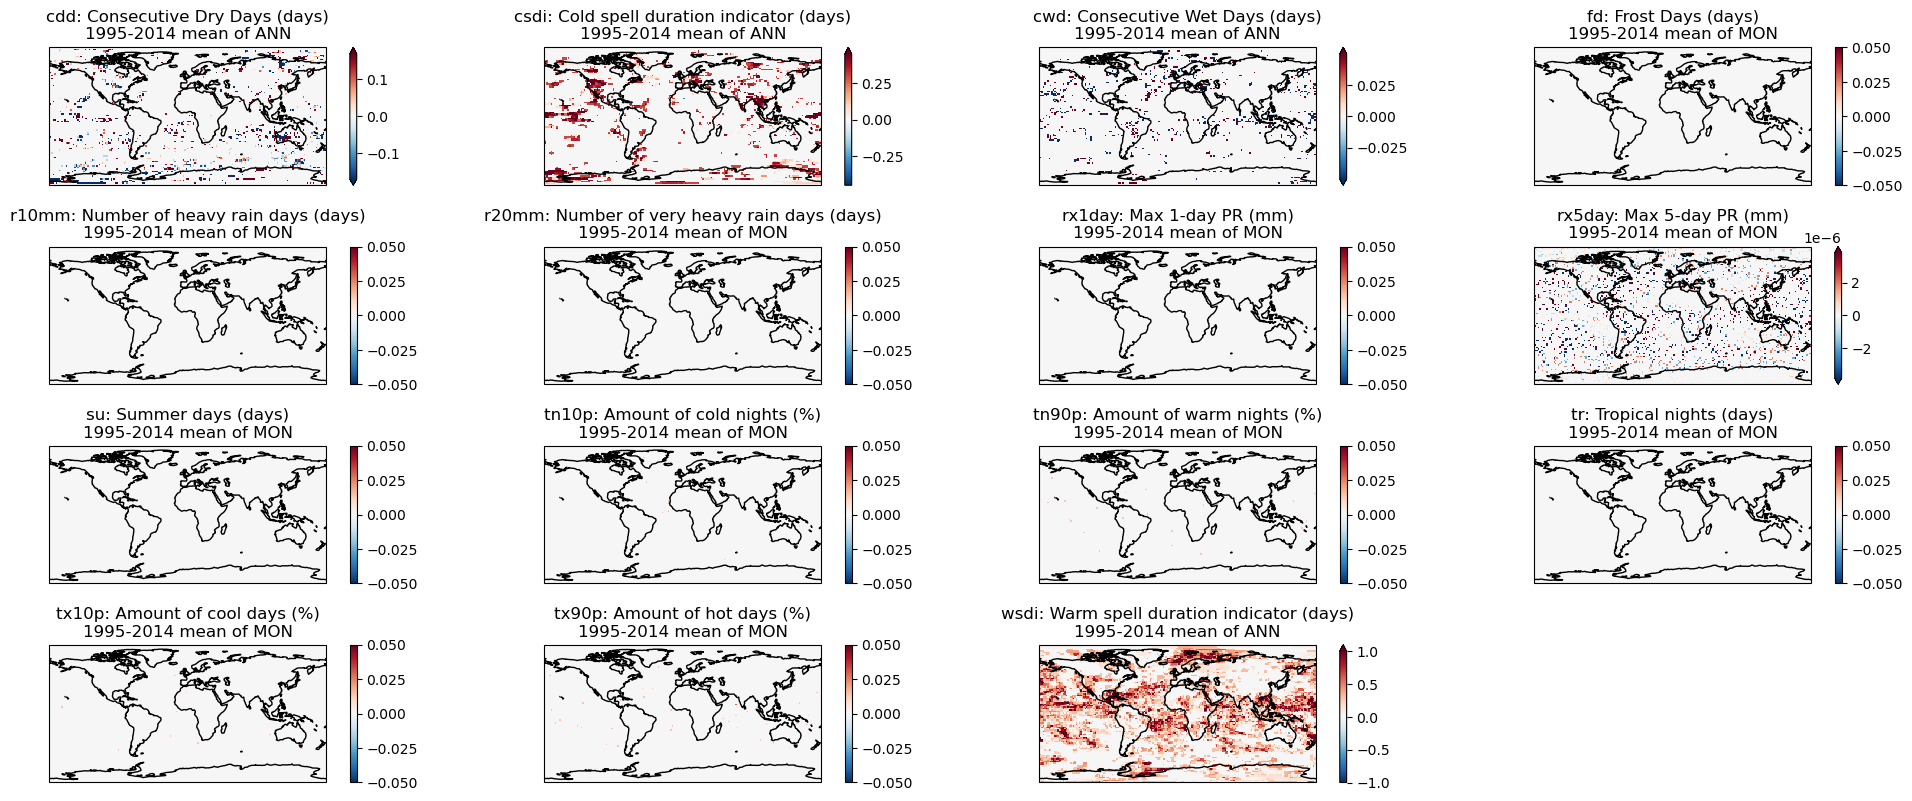

In [23]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(7, 4, subplot_kw={'projection': proj}, figsize=(20, 14))

for idx, index in enumerate(dict_cdo.keys()):
    da = dict_cdo[index]
    ref = dict_cdc[index]
    
    da = da.sel(time=period).mean('time', keep_attrs=True)
    ref = ref.sel(time=period).mean('time', keep_attrs=True)
    
    ax = axes.ravel()[idx]

    if index == 'gsl':  # mask out ocean differences
        plot_map(ax, (da - ref).where(da!=0, 0), robust=True, cmap='RdBu_r', center=0)
    else:
        plot_map(ax, da - ref, robust=True, cmap='RdBu_r', center=0)
    # ax.set_title('{} ({})'.format(index, da.attrs['units']))
    ax.set_title('{}: {} ({})\n{}-{} mean of {}'.format(
        index, ref.attrs.get('long_name', index), da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1

fig.tight_layout()

## Plot maps: cdo - CDS

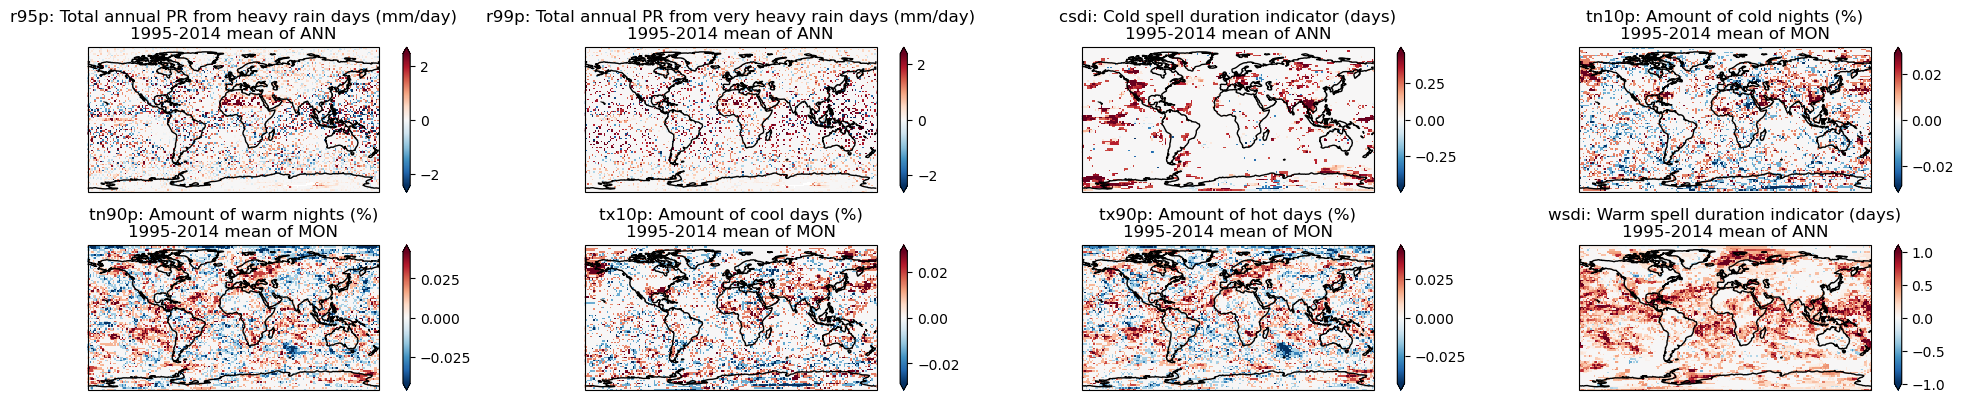

In [22]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(7, 4, subplot_kw={'projection': proj}, figsize=(20, 14))

for idx, index in enumerate(dict_cds.keys()):
    if index not in dict_cdo.keys():
        print(index)
        continue
    da = dict_cdo[index]
    ref = dict_cds[index]
    
    da = da.sel(time=period).mean('time', keep_attrs=True)
    ref = ref.sel(time=period).mean('time', keep_attrs=True)
    
    ax = axes.ravel()[idx]

    if index == 'gsl':  # mask out ocean differences
        plot_map(ax, (da - ref).where(da!=0, 0), robust=True, cmap='RdBu_r', center=0)
    else:
        plot_map(ax, da - ref, robust=True, cmap='RdBu_r', center=0)
    # ax.set_title('{} ({})'.format(index, da.attrs['units']))
    ax.set_title('{}: {} ({})\n{}-{} mean of {}'.format(
        index, dict_cdc[index].attrs.get('long_name', index), da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1

fig.tight_layout()

## Plot maps: ClimDexCalc2 - CDS

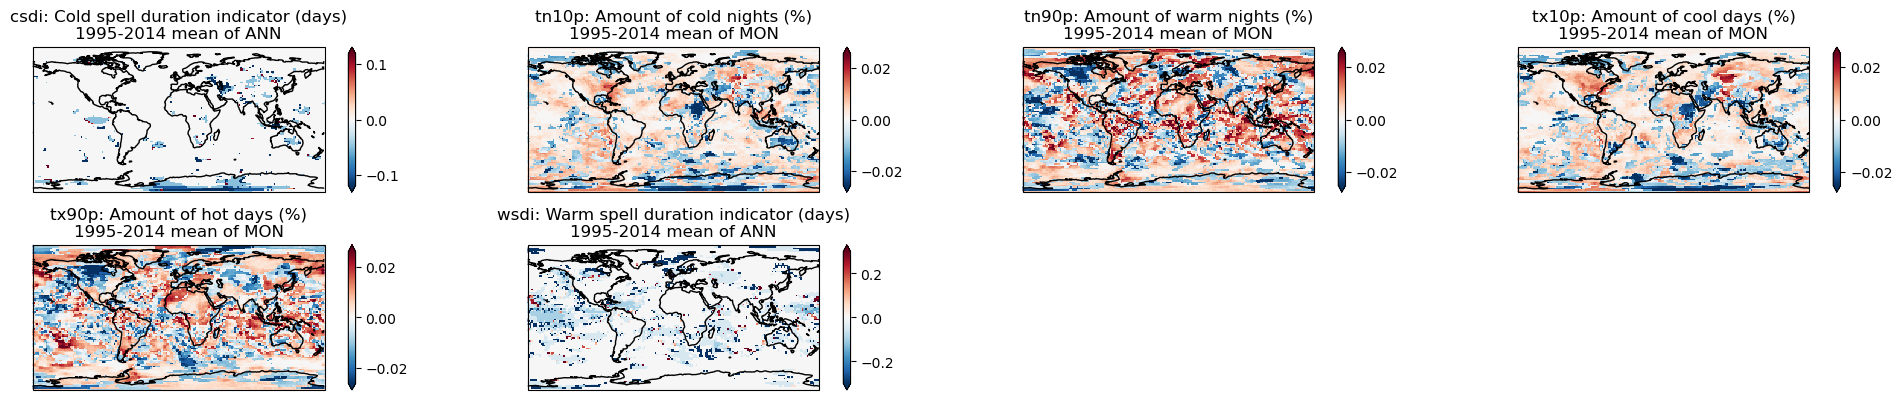

In [25]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(7, 4, subplot_kw={'projection': proj}, figsize=(20, 14))

for idx, index in enumerate(dict_cds.keys()):
    if index not in dict_cdo.keys():
        print(index)
        continue
    da = dict_cdc[index]
    ref = dict_cds[index]
    
    da = da.sel(time=period).mean('time', keep_attrs=True)
    ref = ref.sel(time=period).mean('time', keep_attrs=True)
    
    ax = axes.ravel()[idx]

    if index == 'gsl':  # mask out ocean differences
        plot_map(ax, (da - ref).where(da!=0, 0), robust=True, cmap='RdBu_r', center=0)
    else:
        plot_map(ax, da - ref, robust=True, cmap='RdBu_r', center=0)
    # ax.set_title('{} ({})'.format(index, da.attrs['units']))
    ax.set_title('{}: {} ({})\n{}-{} mean of {}'.format(
        index, dict_cdc[index].attrs.get('long_name', index), da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1

fig.tight_layout()

## Plot maps: ClimDexCalc2

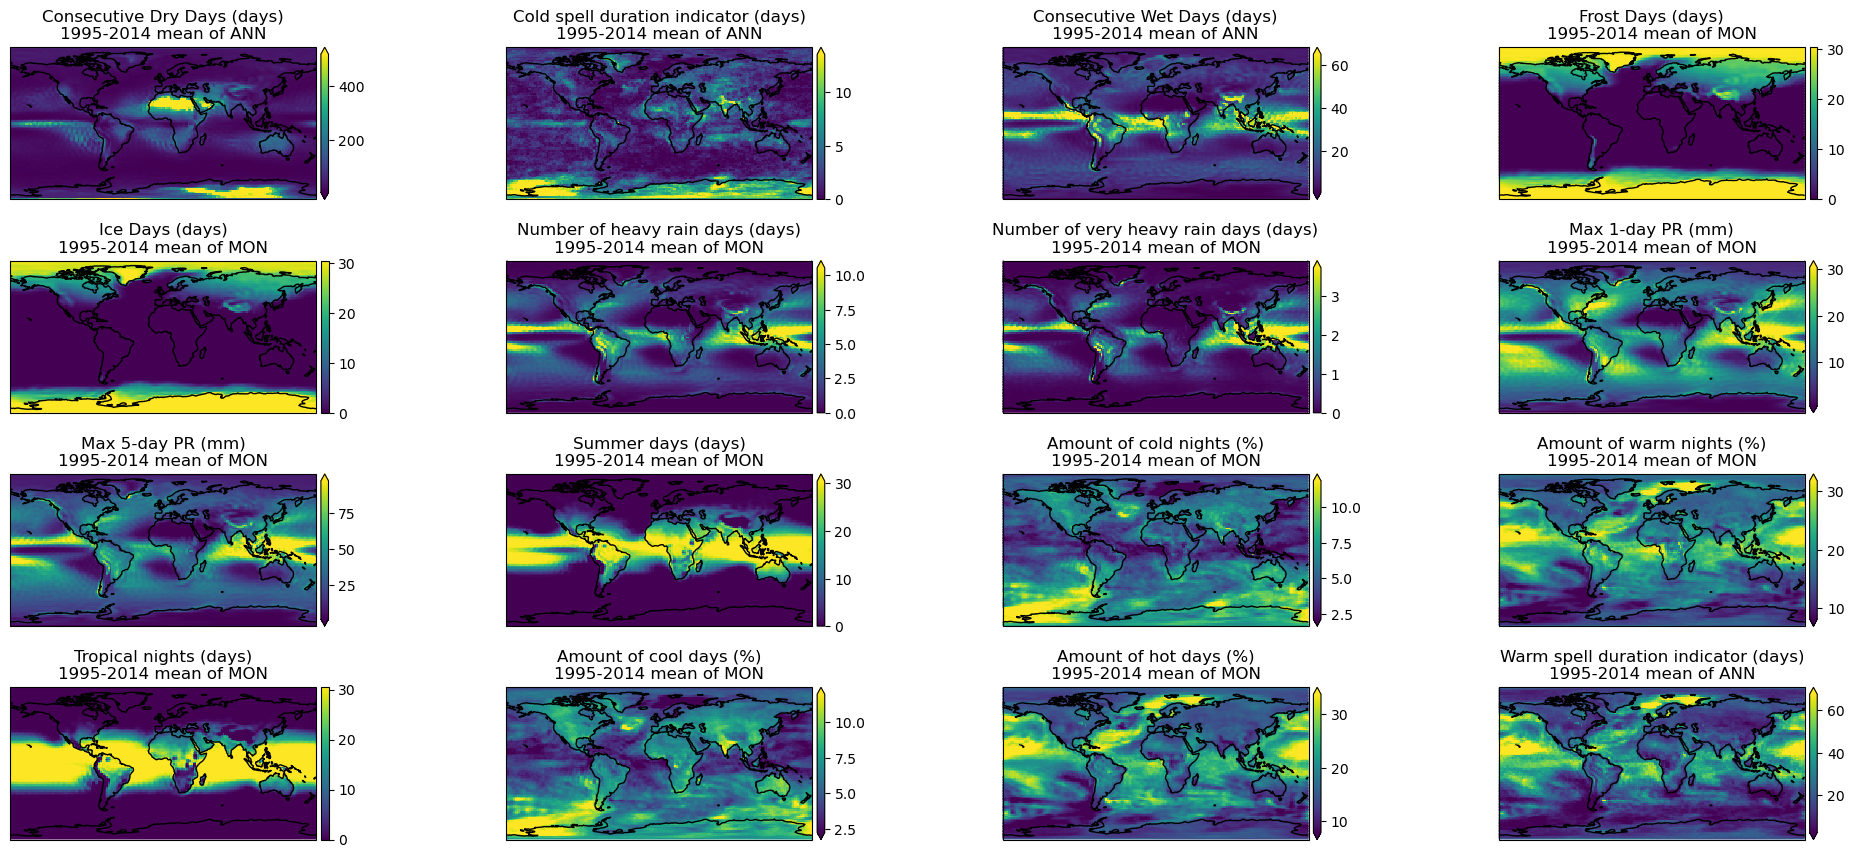

In [23]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(7, 4, subplot_kw={'projection': proj}, figsize=(20, 15))

# dict_long_name = {}

for idx, index in enumerate(dict_cdo.keys()):
    da = dict_cdc[index]
    ax = axes.ravel()[idx]
    da = da.sel(time=period).mean('time', keep_attrs=True)
    plot_map(ax, da, robust=True)
    ax.set_title('{} ({})\n{}-{} mean of {}'.format(
        da.attrs.get('long_name', index), da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))

    # dict_long_name[index] = da.attrs['long_name']
    
idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1

fig.tight_layout()

## Lineplots: cdo

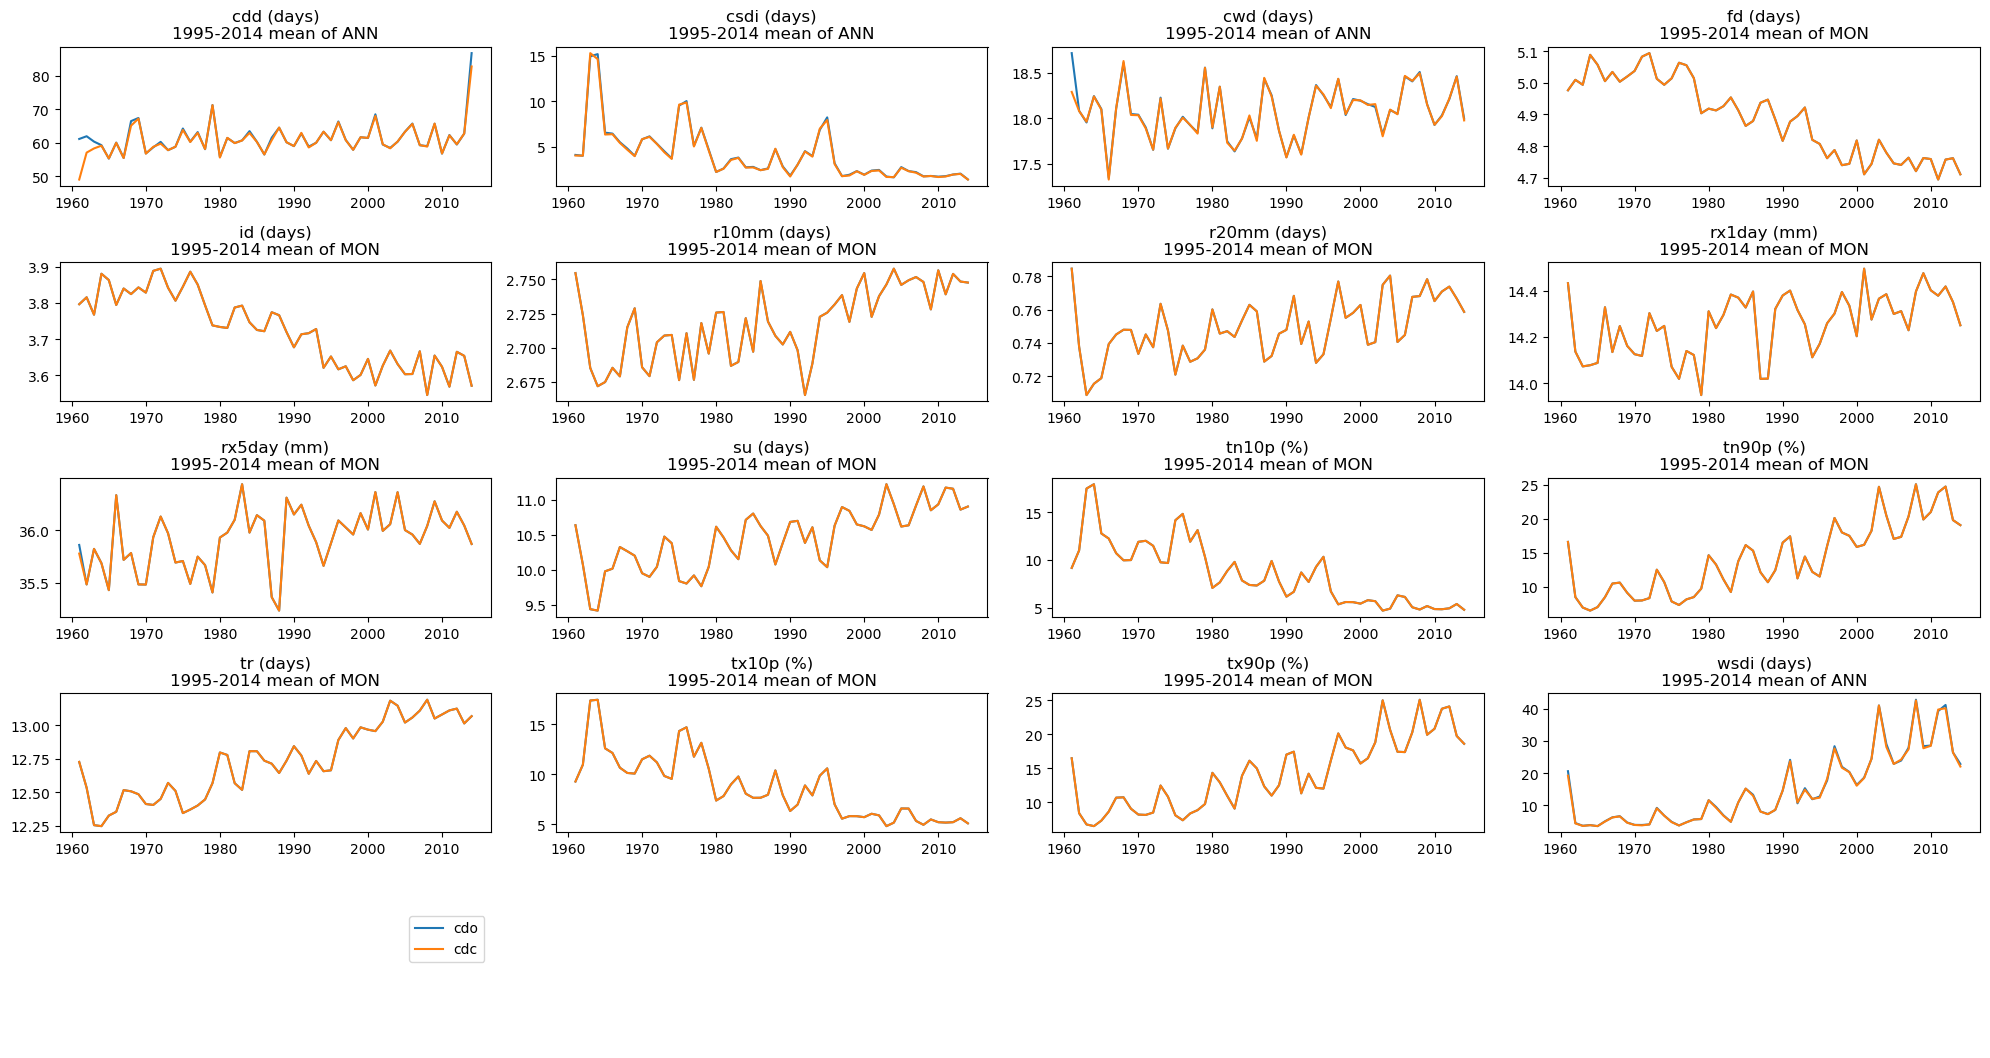

In [24]:
fig, axes = plt.subplots(7, 4, figsize=(20, 15))

for idx, index in enumerate(dict_cdo.keys()):
    da = dict_cdo[index]
    ref = dict_cdc[index]

    ref = area_weighted_mean(ref.sel(time=slice('1961', '2014')).groupby('time.year').mean())
    da = area_weighted_mean(da.sel(time=slice('1961', '2014')).groupby('time.year').mean())
    
    ax = axes.ravel()[idx]
    
    hh1, = ax.plot(da['year'], da, label='cdo')
    hh2, = ax.plot(ref['year'], ref, label='cdc')
    
    ax.set_title('{} ({})\n{}-{} mean of {}'.format(
        index, da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))

idx += 1
ax = axes.ravel()[idx]
ax.axis('off')
ax.legend(handles=[hh1, hh2])

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1
    
fig.tight_layout() 

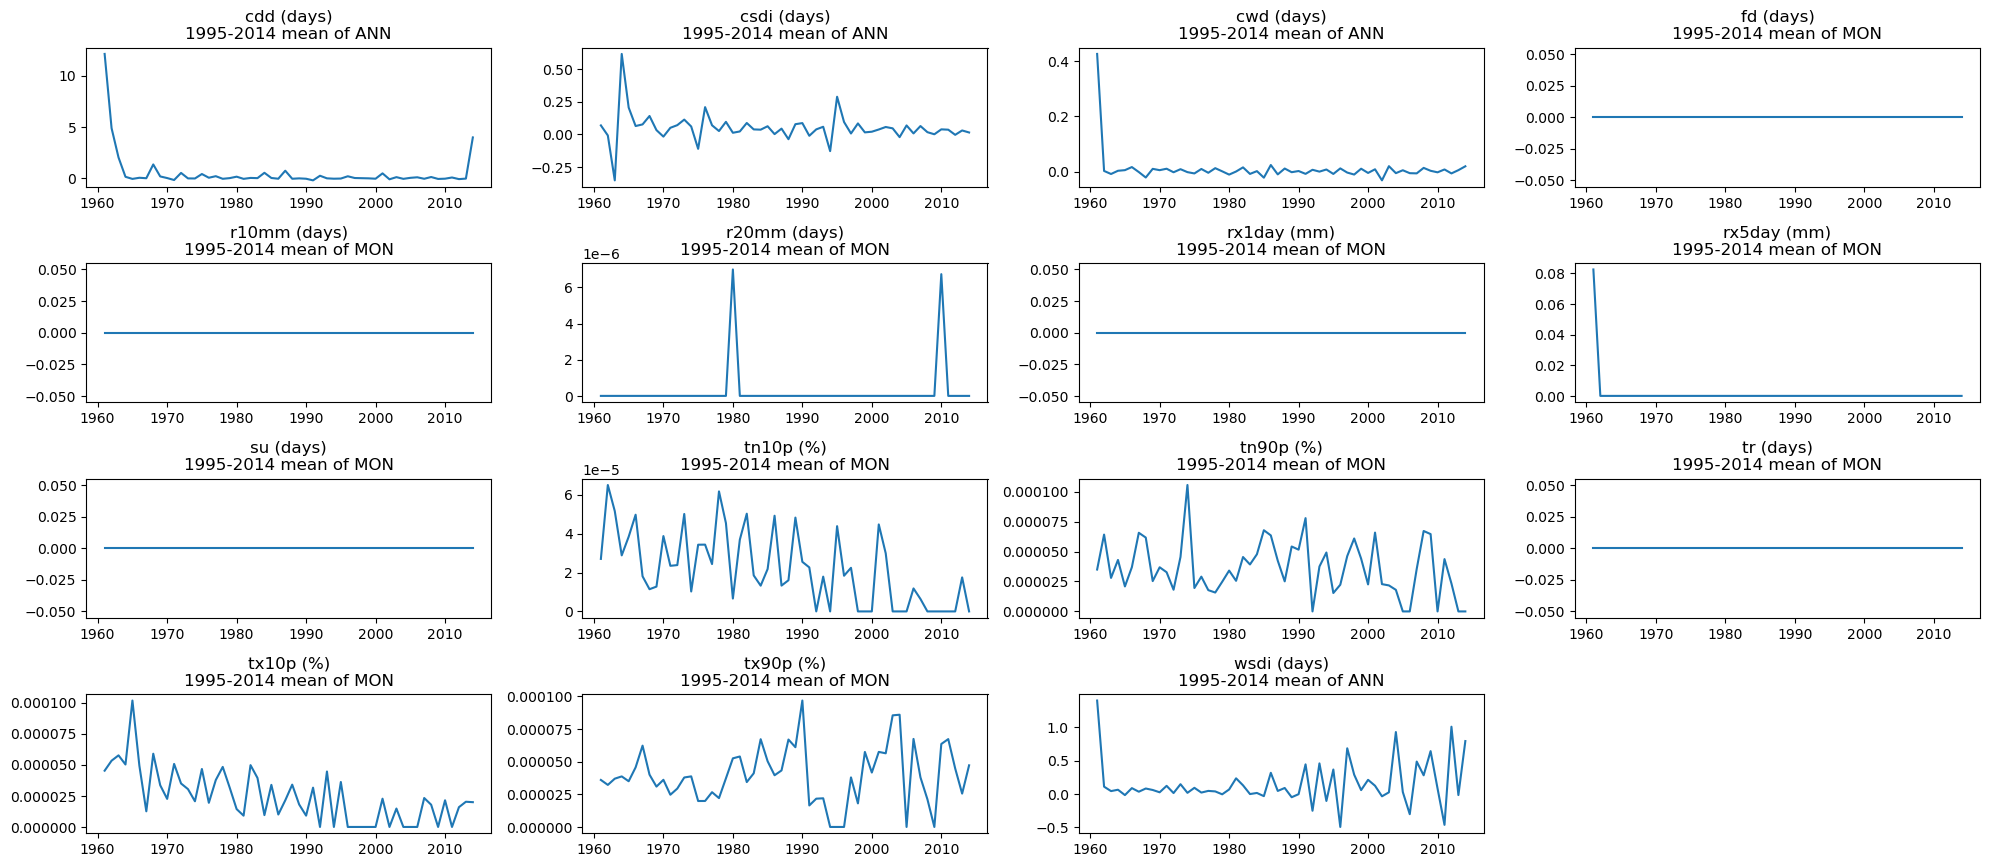

In [24]:
fig, axes = plt.subplots(7, 4, figsize=(20, 15))

for idx, index in enumerate(dict_cdo.keys()):
    da = dict_cdo[index]
    ref = dict_cdc[index]

    ref = area_weighted_mean(ref.sel(time=slice('1961', '2014')).groupby('time.year').mean())
    da = area_weighted_mean(da.sel(time=slice('1961', '2014')).groupby('time.year').mean())
    
    ax = axes.ravel()[idx]
    
    hh1, = ax.plot(da['year'], da - ref)
    
    ax.set_title('{} ({})\n{}-{} mean of {}'.format(
        index, da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))

idx += 1
ax = axes.ravel()[idx]
ax.axis('off')
# ax.legend(handles=[hh1, hh2])

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1
    
fig.tight_layout() 

In [27]:
perc_clim = xr.open_dataset(os.path.join(path, 'climdexcalc2_test', 'percentiles_1day_mpi-esm1-2-lr_historical_r1i1p1f1_1975-1975.nc'))[['tx10thresh', 'tx90thresh', 'tn10thresh', 'tn90thresh']]

In [64]:
dict_cdc['tx90p'].sel(time=slice('1980-02-27', '1980-03-02'))

<xarray.DataArray 'tx90p' (time: 0, lat: 96, lon: 192)> Size: 0B
[0 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 0B 
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
    height   float64 8B 0.0
Attributes:
    long_name:         Amount of hot days
    units:             %
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  48
    comment:           minimum near-surface (usually, 2 meter) air temperatur...
    cell_methods:      area: mean time: minimum
    cell_measures:     area: areacella
    definition:        Monthly percentage of days when TX > 90th percentile
    expert_team:       ETCCDI

In [33]:
tx90p_cdo = xr.open_dataset(os.path.join(path, 'cdo_test2', '90pETCCDI_w5_b1961-1990_doy__tasmax_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231.nc'))['90pETCCDI']

In [47]:
tx90p_cdo

<xarray.DataArray '90pETCCDI' (time: 366, lat: 96, lon: 192)> Size: 27MB
[6746112 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 3kB 1990-01-01T12:00:00 ... 1989-12-31T12:...
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
    height   float64 8B ...
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    units:             K
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  48
    comment:           maximum near-surface (usually, 2 meter) air temperatur...
    cell_methods:      area: mean time: maximum
    cell_measures:     area: areacella
    history:           2019-09-11T14:13:27Z altered by CMOR: Treated scalar d...

(<GeoAxes: xlabel='Longitude [degrees_east]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7ffdc946dbe0>)

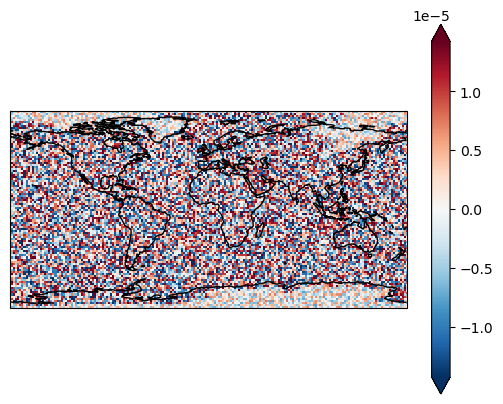

In [48]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
plot_map(ax, tx90p_cdo.isel(time=0) - perc_clim['tx90thresh'].isel(time=0) -273.15, robust=True, cmap='RdBu_r', center=0)

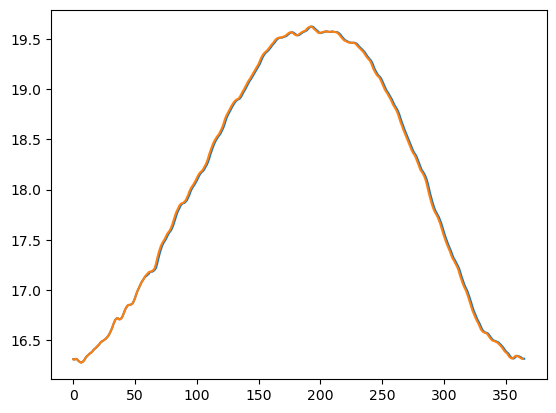

In [52]:
plt.plot(area_weighted_mean(tx90p_cdo - 273.15))
plt.plot(area_weighted_mean(perc_clim['tx90thresh']))

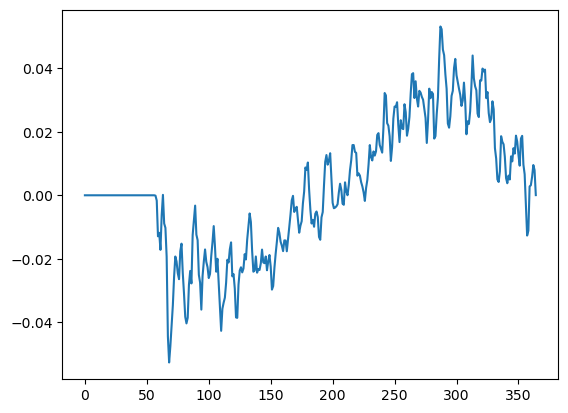

In [55]:
plt.plot(area_weighted_mean(tx90p_cdo - 273.15).values[:-1] - area_weighted_mean(perc_clim['tx90thresh']).values)


In [70]:
ds = xr.open_dataset('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/tasmax_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
ds.convert_calendar('365_day').to_netcdf('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/tasmax_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231_365day.nc')


/tmp/ipykernel_3886385/3506546902.py:2: UserWarning: Variable time has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for time and time_bnds will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for time before writing to a file.
  ds.convert_calendar('365_day').to_netcdf('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/tasmax_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231_365day.nc')


In [71]:
ds = xr.open_dataset('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/tasmin_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
ds.convert_calendar('365_day').to_netcdf('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/tasmin_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231_365day.nc')


/tmp/ipykernel_3886385/1652698021.py:2: UserWarning: Variable time has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for time and time_bnds will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for time before writing to a file.
  ds.convert_calendar('365_day').to_netcdf('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/tasmin_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231_365day.nc')


In [72]:
ds = xr.open_dataset('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/tas_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
ds.convert_calendar('365_day').to_netcdf('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/tas_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231_365day.nc')


/tmp/ipykernel_3886385/3333734718.py:2: UserWarning: Variable time has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for time and time_bnds will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for time before writing to a file.
  ds.convert_calendar('365_day').to_netcdf('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/tas_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231_365day.nc')


In [73]:
ds = xr.open_dataset('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/pr_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
ds.convert_calendar('365_day').to_netcdf('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/pr_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231_365day.nc')


/tmp/ipykernel_3886385/4167527591.py:2: UserWarning: Variable time has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for time and time_bnds will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for time before writing to a file.
  ds.convert_calendar('365_day').to_netcdf('/work/uc1275/LukasBrunner/data/etccdi_cdo/input/pr_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-20141231_365day.nc')
